In [1]:
import os,shutil
import numpy as np
import torch
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Not tested. hard code as below
def MovePicToFolder(meta_csv_file, image_col_name, type_col_name, pic_ext_name = 'jpg'):
    meta_data = pd.read_csv(meta_csv_file)
    
    filename_list = meta_data[image_col_name].values.tolist()
    folder_list = meta_data[type_col_name].values.tolist()
    
    #Create Folder if not exist
    df_group = meta_data.groupby(by = type_col_name)
    Cata_list = list(df_group.groups.keys())
    
    for i in range(len(Cata_list)):
    path = os.path.join(data_folder, Cata_list[i])
    if not os.path.exists(path):
        os.mkdir(path)
        
    # Move pictres to corresponding type folders
    # We can also run multi-thread to do such things, but run only one-time, so .....
    # Just like the Pytorch number_workers
    for i in range(len(filename_list)):
        filename = os.path.join(data_folder, filename_list[i] +'.'+ pic_ext_name)
        foldername = os.path.join(data_folder, folder_list[i])
        shutil.move(filename, foldername)
        
# MovePicToFolder('HAM10000_metadata.csv',)

In [23]:
meta_data = pd.read_csv('HAM10000_metadata.csv')

filename_list = meta_data['image_id'].values.tolist()
folder_list = meta_data['dx'].values.tolist()

df_group = meta_data.groupby(by = 'dx')
Cata_list = list(df_group.groups.keys())
Cata_list
data_folder = 'NewData'
for i in range(len(filename_list)):
    filename = os.path.join(data_folder, filename_list[i]+'.jpg')
    foldername = os.path.join(data_folder, folder_list[i])
    shutil.move(filename, foldername)
    

In [8]:
#Validate the folder classfiy correctly
meta_data = pd.read_csv('HAM10000_metadata.csv')
filename_list = meta_data['image_id'].values.tolist()
filetype_list = meta_data['dx'].values.tolist()
dict_type = dict(zip(filename_list, filetype_list))

df_group = meta_data.groupby(by = 'dx')
Cata_list = list(df_group.groups.keys())
data_folder = 'NewData'

total_corret = 0

for i in range(len(Cata_list)):
    SubFoldeNname = os.path.join(data_folder,Cata_list[i])
    print("SubFolder name is {}".format(SubFoldeNname))
    
    for sub_file in os.listdir(SubFoldeNname):
        sub_file = os.path.splitext(sub_file)[0]
        if dict_type[sub_file] == Cata_list[i]:
            total_corret += 1
        else:
            print('%s is not %s, correct type is %s',sub_file, SubFoldeNname, dict_type[sub_file])

print("Total correct number is:",total_corret)

SubFolder name is NewData\akiec
SubFolder name is NewData\bcc
SubFolder name is NewData\bkl
SubFolder name is NewData\df
SubFolder name is NewData\mel
SubFolder name is NewData\nv
SubFolder name is NewData\vasc
Total correct number is: 10015


In [4]:
from enum import Enum
class ModelType(Enum):
    RESNET = 1
    VGG = 2
    OTHER = 3
    
modeltype = ModelType.RESNET
modeltype

In [4]:
## Load and Transform our Data
# Orignal Data download from https://github.com/udacity/dermatologist-ai

#data_dir = 'd:\\Data\\'
#train_dir = os.path.join(data_dir, 'train')
#test_dir = os.path.join(data_dir, 'test')
#valid_dir = os.path.join(data_dir, 'valid')

# classes are folders in each directory with these names
#classes = ['melanoma', 'nevus', 'seborrheic_keratosis']


In [9]:
## Load and Transform our Data
# Orignal Data download from https://github.com/udacity/dermatologist-ai
data_folder = 'NewData'
data_dir = data_folder 

# classes are folders in each directory with these names
classes = Cata_list

valid_size = 0.05
train_size = 0.8
test_size = 0.15

In [25]:
def CheckFileAccuracy(train_dir,filename = 'metadata.csv'):
    #metadata.csv contains the classfy info
    # We only need to verify 
    meta_data = pd.read_csv('metadata.csv')

    lista = meta_data['name'].values.tolist()
    listb = meta_data['meta.clinical.diagnosis'].values.tolist()

    dict_type = dict(zip(lista, listb))

    melanoma_correct = 0
    nevus_correct = 0
    seb_correct = 0
    
    train_dir_mela = os.path.join(train_dir,'melanoma')
    train_dir_nevus = os.path.join(train_dir,'nevus')
    train_dir_seb = os.path.join(train_dir,'seborrheic_keratosis')

    for file in os.listdir(train_dir_mela):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'melanoma':
            melanoma_correct += 1
        else:
            print('%s is not melanoma, correct type is %s',file, dict_type[file])

    for file in os.listdir(train_dir_nevus):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'nevus':
            nevus_correct += 1
        else:
            print('%s is not nevus, correct type is %s',file, dict_type[file])

    for file in os.listdir(train_dir_seb):
        file = os.path.splitext(file)[0]
        if dict_type[file] == 'seborrheic keratosis':
            seb_correct += 1
        else:
            print('%s is not seborrheic_keratosis, correct type is %s',file, dict_type[file])
    
    print('melanoma Accuracy %d / %d' %( melanoma_correct ,len(os.listdir(train_dir_mela))))
    print('nevus Accuracy %d / %d' %(nevus_correct ,len(os.listdir(train_dir_nevus))))
    print('seborrheic keratosis Accuracy %d / %d' %( seb_correct ,len(os.listdir(train_dir_seb))))
    
CheckFileAccuracy(train_dir)
CheckFileAccuracy(valid_dir)


In [10]:
#Randowm Resize 
data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(), 
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        ])

train_data = datasets.ImageFolder(data_folder, transform=data_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

# Train Split 
train_valid_split = int(np.floor((train_size+valid_size) * num_train)) 
valid_split = int(np.floor( train_size* num_train))

train_valid_idx, test_idx = indices[:train_valid_split], indices[train_valid_split:]
train_idx, valid_idx = indices[ :valid_split], indices[valid_split:train_valid_split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)


In [11]:
batch_size = 64
num_workers=5
train_data = datasets.ImageFolder(data_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [7]:

print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))

print("--------------")
print(train_valid_split)
print(valid_split)

8012
500
1503
--------------
8512
8012


In [12]:
# Deprecated
#Randowm Resize 
data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(), 
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform) 

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

NameError: name 'train_dir' is not defined

In [13]:
batch_size = 64
num_workers=5

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True,drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True,drop_last=True)

NameError: name 'valid_data' is not defined

In [12]:
def visual_data(data_loader,row_num,col_num):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(row_num*col_num):
        ax = fig.add_subplot(col_num, row_num, idx+1, xticks=[], yticks=[])
        
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

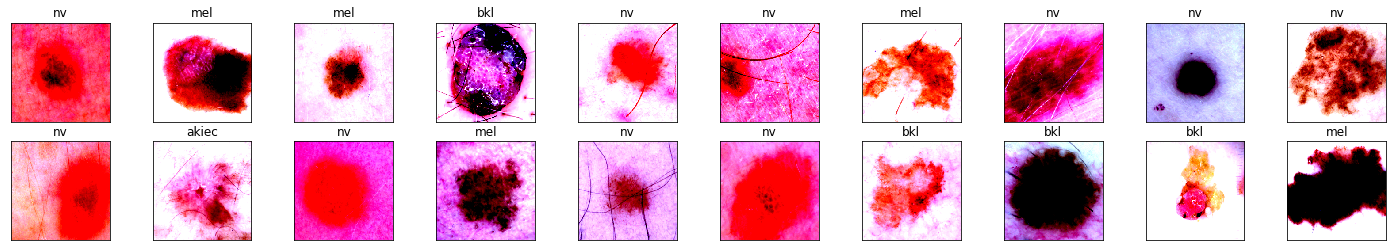

In [13]:
visual_data(train_loader,10,2)

In [14]:
if modeltype == ModelType.RESNET:
    training_model = models.resnext101_32x8d(pretrained=True)
if modeltype == ModelType.VGG:
    training_model = models.vgg19(pretrained=True)
    
#Freeze the parameters
for param in training_model.parameters():
    param.requires_grad_(False)
    
print(training_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
full_connected_layers = nn.Sequential(nn.Linear(resnet_50.fc.in_features, 1024),
                          nn.BatchNorm1d(1024),
                          nn.ReLU(),
                          nn.Dropout(0.4),
                          nn.Linear(1024, 512),
                          nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(0.4),
                          nn.Linear(512, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(0.4),            
                          nn.Linear(256, 128),
                          nn.BatchNorm1d(128),
                          nn.ReLU(),
                          nn.Dropout(0.4),            
                          nn.Linear(128, len(classes))) 


full_connected_layers = nn.Sequential(nn.Linear(resnet_50.fc.in_features, 1024),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.2),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Dropout(0.2),            
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(0.2),            
                          nn.Linear(128, len(classes)) ) 



In [18]:
full_connected_layers_new = nn.Sequential(nn.Linear(training_model.fc.in_features, 512),
                          #nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(512, 128),
                          #nn.BatchNorm1d(128),
                          nn.ReLU(),
                          nn.Dropout(0.5),            
                          nn.Linear(128, len(classes))) 

training_model.fc= full_connected_layers_new#full_connected_layers

# if GPU is available, move the model to GPU
if train_on_gpu:
    training_model.cuda()

print(training_model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=7, bias=True)
)


In [12]:
full_connected_layers_vgg= nn.Sequential(nn.Linear(vgg19.classifier[0].in_features, 512),
                          #nn.BatchNorm1d(512),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(512, 128),
                          #nn.BatchNorm1d(128),
                          nn.ReLU(),
                          nn.Dropout(0.5),            
                          nn.Linear(128, len(classes))) 

training_model.classifier = full_connected_layers_vgg

if train_on_gpu:
    vgg19.cuda()

print(vgg19.classifier)

In [33]:
import torch.optim as optim
#Learning rate
lr = 0.001
n_epochs = 20

#class_wight name : akiec, bcc, bkl, df, mel, nv, vasc
class_wight =torch.FloatTensor([1,1,1,1,1,0.5,1])

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss(weight=class_wight.cuda())

# specify optimizer (Adam) and learning rate = 0.0001
optimizer = optim.Adam(training_model.fc.parameters(), lr=lr)

In [19]:
train_loss_list = list()
valid_loss_list = list()

#If train and valid_loss less than np.inf  save the valid_loss
#Or shall we do some linear combination train_loss_min and valid_loss_min? such as α*train_loss_min + β*valid_loss_min

train_loss_min = np.inf

model_dir = 'D:\\Data\\'
model_name = 'model_resnet_50.pt'
save_path = model_dir + model_name

In [20]:
training_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [25]:
def train_net(train_model,n_epochs, train_loss_list, valid_loss_list,criterion,optimizer ):
    valid_loss_min = np.inf
    train_loss_min = np.inf
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        ######################    
        # Training the model #
        ###################### 
        train_model.train()
        train_loss = 0.0
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, (data, target) in enumerate(train_loader):
            
            if train_on_gpu: 
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            
            output = train_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = (train_loss * batch_i + loss.data) /  (batch_i + 1)
            train_loss_list.append(train_loss)
            print('Batch_i: {} \tTraining Loss: {:.6f} \t'.format(batch_i, train_loss,))
        ######################    
        # Valid the model #
        ###################### 
        train_model.eval()
        valid_loss = 0
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            output = train_model(data)
            loss = criterion(output, target)
            
            valid_loss = (valid_loss * batch_i + loss.data) /  (batch_i + 1)
            valid_loss_list.append(valid_loss)
        # print loss statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if train_loss < train_loss_min:
            train_loss_min = train_loss
            torch.save(train_model.state_dict(), save_path )

    print('Finished Training')


In [34]:
#torch.autograd.set_detect_anomaly(True)
n_epochs = 6
#train_net(resnet_50,n_epochs,train_loss_list, valid_loss_list)
train_net(training_model,n_epochs,train_loss_list, valid_loss_list,criterion, optimizer)

Batch_i: 0 	Training Loss: 0.720251 	
Batch_i: 1 	Training Loss: 0.843413 	
Batch_i: 2 	Training Loss: 0.899731 	
Batch_i: 3 	Training Loss: 0.870783 	
Batch_i: 4 	Training Loss: 0.864288 	
Batch_i: 5 	Training Loss: 0.864902 	
Batch_i: 6 	Training Loss: 0.865371 	
Batch_i: 7 	Training Loss: 0.864380 	
Batch_i: 8 	Training Loss: 0.928201 	
Batch_i: 9 	Training Loss: 0.941999 	
Batch_i: 10 	Training Loss: 0.908278 	
Batch_i: 11 	Training Loss: 0.952174 	
Batch_i: 12 	Training Loss: 0.941390 	
Batch_i: 13 	Training Loss: 0.916446 	
Batch_i: 14 	Training Loss: 0.941174 	
Batch_i: 15 	Training Loss: 0.942980 	
Batch_i: 16 	Training Loss: 0.951445 	
Batch_i: 17 	Training Loss: 0.956187 	
Batch_i: 18 	Training Loss: 0.955257 	
Batch_i: 19 	Training Loss: 0.947314 	
Batch_i: 20 	Training Loss: 0.947618 	
Batch_i: 21 	Training Loss: 0.952307 	
Batch_i: 22 	Training Loss: 0.960435 	
Batch_i: 23 	Training Loss: 0.964387 	
Batch_i: 24 	Training Loss: 0.962292 	
Batch_i: 25 	Training Loss: 0.95402

Batch_i: 83 	Training Loss: 0.860093 	
Batch_i: 84 	Training Loss: 0.860940 	
Batch_i: 85 	Training Loss: 0.862114 	
Batch_i: 86 	Training Loss: 0.863791 	
Batch_i: 87 	Training Loss: 0.863259 	
Batch_i: 88 	Training Loss: 0.861108 	
Batch_i: 89 	Training Loss: 0.860578 	
Batch_i: 90 	Training Loss: 0.859108 	
Batch_i: 91 	Training Loss: 0.859688 	
Batch_i: 92 	Training Loss: 0.857023 	
Batch_i: 93 	Training Loss: 0.856148 	
Batch_i: 94 	Training Loss: 0.853755 	
Batch_i: 95 	Training Loss: 0.852801 	
Batch_i: 96 	Training Loss: 0.855605 	
Batch_i: 97 	Training Loss: 0.853966 	
Batch_i: 98 	Training Loss: 0.851980 	
Batch_i: 99 	Training Loss: 0.854724 	
Batch_i: 100 	Training Loss: 0.854975 	
Batch_i: 101 	Training Loss: 0.854767 	
Batch_i: 102 	Training Loss: 0.853104 	
Batch_i: 103 	Training Loss: 0.851199 	
Batch_i: 104 	Training Loss: 0.850765 	
Batch_i: 105 	Training Loss: 0.851328 	
Batch_i: 106 	Training Loss: 0.851106 	
Batch_i: 107 	Training Loss: 0.852681 	
Batch_i: 108 	Tra

Batch_i: 38 	Training Loss: 0.844630 	
Batch_i: 39 	Training Loss: 0.846476 	
Batch_i: 40 	Training Loss: 0.845169 	
Batch_i: 41 	Training Loss: 0.844096 	
Batch_i: 42 	Training Loss: 0.842268 	
Batch_i: 43 	Training Loss: 0.843120 	
Batch_i: 44 	Training Loss: 0.840126 	
Batch_i: 45 	Training Loss: 0.837662 	
Batch_i: 46 	Training Loss: 0.841721 	
Batch_i: 47 	Training Loss: 0.838308 	
Batch_i: 48 	Training Loss: 0.841343 	
Batch_i: 49 	Training Loss: 0.843143 	
Batch_i: 50 	Training Loss: 0.846727 	
Batch_i: 51 	Training Loss: 0.849681 	
Batch_i: 52 	Training Loss: 0.846072 	
Batch_i: 53 	Training Loss: 0.842790 	
Batch_i: 54 	Training Loss: 0.842246 	
Batch_i: 55 	Training Loss: 0.840358 	
Batch_i: 56 	Training Loss: 0.839822 	
Batch_i: 57 	Training Loss: 0.841252 	
Batch_i: 58 	Training Loss: 0.841800 	
Batch_i: 59 	Training Loss: 0.837005 	
Batch_i: 60 	Training Loss: 0.836415 	
Batch_i: 61 	Training Loss: 0.834596 	
Batch_i: 62 	Training Loss: 0.836086 	
Batch_i: 63 	Training Los

Batch_i: 120 	Training Loss: 0.793723 	
Batch_i: 121 	Training Loss: 0.795094 	
Batch_i: 122 	Training Loss: 0.796329 	
Batch_i: 123 	Training Loss: 0.795381 	
Batch_i: 124 	Training Loss: 0.796914 	
Batch_i: 125 	Training Loss: 0.794543 	
Epoch: 4 	Training Loss: 0.794543 	Validation Loss: 0.046048
Batch_i: 0 	Training Loss: 1.017518 	
Batch_i: 1 	Training Loss: 0.814288 	
Batch_i: 2 	Training Loss: 0.804153 	
Batch_i: 3 	Training Loss: 0.779084 	
Batch_i: 4 	Training Loss: 0.779601 	
Batch_i: 5 	Training Loss: 0.761053 	
Batch_i: 6 	Training Loss: 0.737909 	
Batch_i: 7 	Training Loss: 0.766794 	
Batch_i: 8 	Training Loss: 0.768210 	
Batch_i: 9 	Training Loss: 0.776742 	
Batch_i: 10 	Training Loss: 0.779602 	
Batch_i: 11 	Training Loss: 0.787891 	
Batch_i: 12 	Training Loss: 0.789013 	
Batch_i: 13 	Training Loss: 0.765502 	
Batch_i: 14 	Training Loss: 0.755761 	
Batch_i: 15 	Training Loss: 0.756351 	
Batch_i: 16 	Training Loss: 0.759661 	
Batch_i: 17 	Training Loss: 0.759563 	
Batch_i

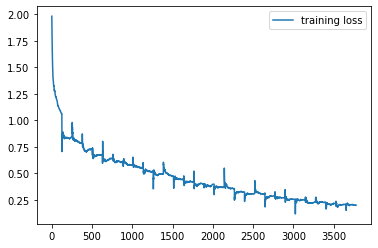

In [53]:
plt.plot(train_loss_list,label = "training loss")
plt.legend()

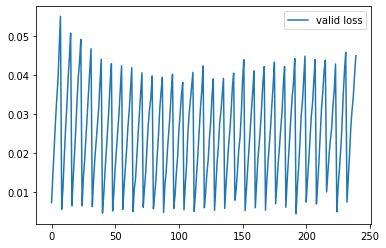

In [54]:
plt.plot(valid_loss_list,label = "valid loss")
plt.legend()

In [28]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

In [37]:
# This is test_code
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    print(data[0].name)
    
    
    break
    

None


In [35]:
for batch_idx,(data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    #output = resnet_50(data)
    output = training_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)   
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(data)):   
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
        
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

    

Test Loss: 0.123030

Test Accuracy of akiec: 57% (83/144)
Test Accuracy of   bcc: 60% (127/210)
Test Accuracy of   bkl: 51% (224/432)
Test Accuracy of    df: 34% (22/63)
Test Accuracy of   mel: 56% (302/537)
Test Accuracy of    nv: 91% (2812/3075)
Test Accuracy of  vasc: 66% (32/48)

Test Accuracy (Overall): 79% (3602/4509)


In [58]:
class_total

[49.0, 89.0, 167.0, 17.0, 165.0, 999.0, 17.0]